In [1]:
%pylab inline

import matplotlib as mpl

import galsim as gs
import mccd


Populating the interactive namespace from numpy and matplotlib


# Generate atmosphere realization


In [2]:
"""
CFIS data

Pixel size = 13.5 micrometers
Pixel scale = 0.187 arcsec/pixel

"""

pix_scale = 0.187  # arcsec/pixel

# Get the maximum values for the global positions (in pixels])
loc2glob = mccd.mccd_utils.Loc2Glob()
max_x = loc2glob.x_npix * 6 + loc2glob.x_gap * 5
min_x = loc2glob.x_npix * (-5) + loc2glob.x_gap * (-5)
max_y = loc2glob.y_npix * 2 + loc2glob.y_gap * 1
min_y = loc2glob.y_npix * (-2) + loc2glob.y_gap * (-2)


# Max absolute value in pixels
# This gives us the maximum value of a square [-max_val, max_val]^2 
max_val = np.max(abs(np.array([max_x, min_x, max_y, min_y])))
# Convert to total arcsec. As it is the total we need to multiply by two.
total_arcsec = 2* max_val * pix_scale
# For CFIS this given ~ 4676.06
# We want to use a power of 2 for the FFTs so we fix the `ngrid` variable
# and we adjust the `grid_spacing`
ngrid = 2048 # 4096 # 8192
# `grid_spacing` is in arcsec/grid_point
grid_spacing = total_arcsec/ngrid




In [3]:

print((-ngrid/2 + 0.5)*grid_spacing)
print((ngrid/2 - 0.5)*grid_spacing)

-2362.1520419921876
2362.1520419921876


In [4]:
grid_spacing

2.307916015625

In [5]:
4676/60

77.93333333333334

In [6]:
# Print important quantities of the realization

print('pix_scale: \t', pix_scale, '[arcsec/pixel]')
print('grid_spacing: \t', grid_spacing, '[arcsec]')
print('ngrid: \t\t', ngrid, '[gridpoints]')
print('total_arcsec: \t', total_arcsec, '[arcsec]')



pix_scale: 	 0.187 [arcsec/pixel]
grid_spacing: 	 2.307916015625 [arcsec]
ngrid: 		 2048 [gridpoints]
total_arcsec: 	 4726.612 [arcsec]


In [7]:
# Definition of the power function

def power_fun(l, theta=2.75*60):
    """ Von Karman power function.
    
    Parameters should be in arcsec.
    Heymans' parameter for the CFHT telescope is theta ~3 arcmin 
    """
    return (l**2 + 1/(theta**2))**(-11/6) * np.exp(-l**2)


In [8]:

# power_f = lambda k : np.exp(-k**2) 

my_ps = gs.PowerSpectrum(e_power_function = power_fun,
                         b_power_function = power_fun)

g1, g2, kappa = my_ps.buildGrid(grid_spacing = grid_spacing,
                                ngrid = ngrid,
                                get_convergence=True,
                                rng = gs.BaseDeviate(123458),
                                bandlimit = 'soft',
                                variance = 0.008**2)

# g1, g2, kappa = my_ps.buildGrid(grid_spacing = grid_spacing,
#                                 ngrid = ngrid,
#                                 get_convergence=True,
#                                 rng = gs.BaseDeviate(123456))


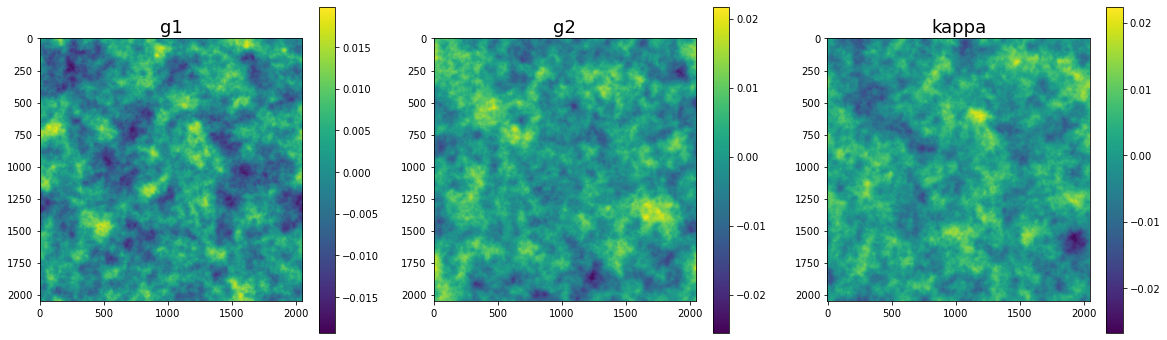

In [31]:
# Plotting all the focal plane

figure(figsize=(20,6))

subplot(131)
imshow(g1);colorbar()
gca().set_title('g1', fontsize='18')

subplot(132)
imshow(g2);colorbar()
gca().set_title('g2', fontsize='18')

subplot(133)
imshow(kappa);colorbar()
gca().set_title('kappa', fontsize='18')

show()


In [10]:
# Plotting one CCD

# We want to calculate how many grid points represent the CCD dimension

# Only on one CCD. Number of pixels
pix_x = 2048
pix_y = 4612
# Now CCD dimensions in arcsec
arcsec_ccd_x = pix_x * pix_scale
arcsec_ccd_y = pix_y * pix_scale
# Now in grid points
p_ccd_x = int(np.ceil(arcsec_ccd_x/grid_spacing))
p_ccd_y = int(np.ceil(arcsec_ccd_y/grid_spacing))



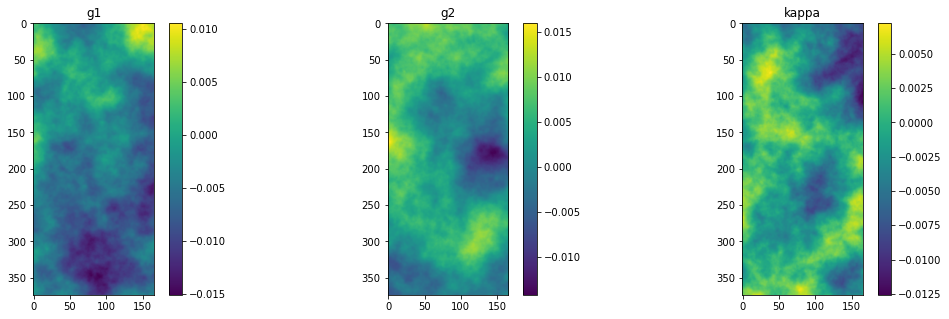

In [11]:
corner = 500

figure(figsize=(18,5))

subplot(131)
imshow(g1[corner:corner+p_ccd_x, corner:corner+p_ccd_y].T);colorbar()
gca().set_title('g1')

subplot(132)
imshow(g2[corner:corner+p_ccd_x, corner:corner+p_ccd_y].T);colorbar()
gca().set_title('g2')

subplot(133)
imshow(kappa[corner:corner+p_ccd_x, corner:corner+p_ccd_y].T);colorbar()
gca().set_title('kappa')

show()

# Test the interpolation

In [33]:
# Let's try to get some positions

new_ngrid = 2047

min_pos = (-new_ngrid/2 + 0.5) * grid_spacing
max_pos = (new_ngrid/2 - 0.5) * grid_spacing
xx, yy = np.meshgrid(np.arange(min_pos, max_pos + grid_spacing, grid_spacing),
                     np.arange(min_pos, max_pos + grid_spacing, grid_spacing))


In [35]:
# new_g1, new_g2 = my_ps.getShear( [xx.flatten(), yy.flatten()] )

new_g1, new_g2, new_mu = my_ps.getLensing([xx.flatten(), yy.flatten()], periodic=True)


In [36]:
new_g1 = new_g1.reshape(xx.shape)
new_g2 = new_g2.reshape(xx.shape)
new_mu = new_mu.reshape(xx.shape)


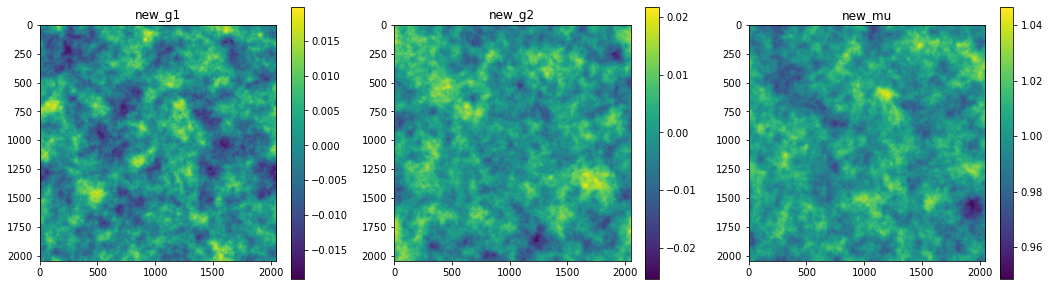

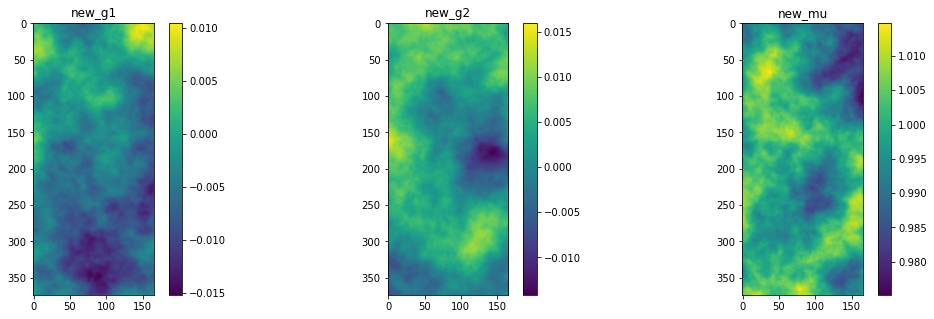

In [37]:

# Plotting all the focal plane

figure(figsize=(18,5))

subplot(131)
imshow(new_g1);colorbar()
gca().set_title('new_g1')

subplot(132)
imshow(new_g2);colorbar()
gca().set_title('new_g2')

subplot(133)
imshow(new_mu);colorbar()
gca().set_title('new_mu')

show()



figure(figsize=(18,5))

subplot(131)
imshow(new_g1[corner:corner+p_ccd_x, corner:corner+p_ccd_y].T);colorbar()
gca().set_title('new_g1')

subplot(132)
imshow(new_g2[corner:corner+p_ccd_x, corner:corner+p_ccd_y].T);colorbar()
gca().set_title('new_g2')

subplot(133)
imshow(new_mu[corner:corner+p_ccd_x, corner:corner+p_ccd_y].T);colorbar()
gca().set_title('new_mu')

show()




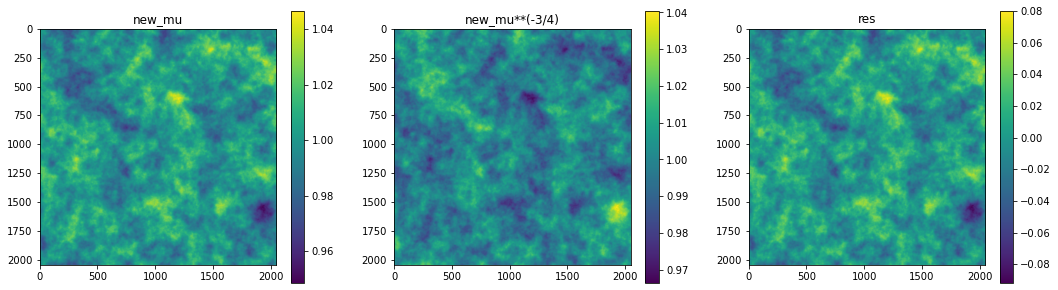

In [38]:
# Compare the maginification `mu` and the `mu**(-3/4)` that is used in the Sheldon 2020 paper

figure(figsize=(18,5))

subplot(131)
imshow(new_mu);colorbar()
gca().set_title('new_mu')

subplot(132)
imshow(new_mu**(-3/4));colorbar()
gca().set_title('new_mu**(-3/4)')

subplot(133)
imshow(new_mu - new_mu**(-3/4));colorbar()
gca().set_title('res')

show()






# Test correlation function

In [18]:
kmin_factor = 10
kmax_factor = 10

kmin = 2. * pi / (ngrid * grid_spacing) / kmin_factor
print('kmin: ', kmin)

kmax = pi / grid_spacing * kmax_factor
print('kmax: ', kmax)


kmin:  0.00013293211516366451
kmax:  13.612248592759247


In [19]:


theta, xi_p, xi_m = my_ps.calculateXi(grid_spacing,
                                      ngrid,
                                      kmax_factor=10,
                                      kmin_factor=10,
                                      n_theta=100,
                                      bandlimit='hard')



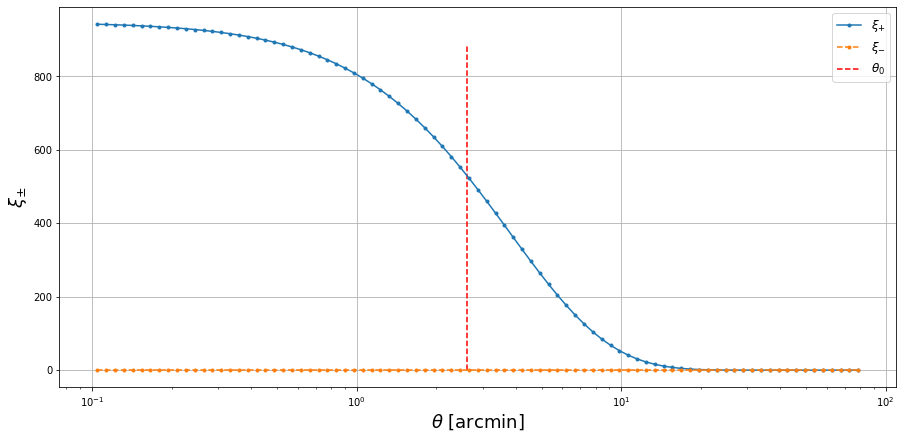

In [20]:

theta_min = theta/60
theta_zero = 2.62

plt.figure(figsize=(15,7))
semilogx(theta_min[theta_min>0.1], xi_p[theta_min>0.1], '-o', label=r'$\xi_{+}$', markersize=3)
semilogx(theta_min[theta_min>0.1], xi_m[theta_min>0.1], '--o', label=r'$\xi_{-}$', markersize=3)
mpl.pyplot.vlines(theta_zero, np.min(xi_p[theta_min>0.5]), np.max(xi_p[theta_min>0.5]),
                  colors='r', linestyles='dashed', label=r'$\theta_{0}$')
grid('minor')
xlabel(r'$\theta$ [arcmin]', fontsize=18)
ylabel(r'$\xi_{\pm}$', fontsize=18)
legend(fontsize=12)
plt.show()

# I think there is a normalization factor missing in the correlation values to adjust the axis.
# Need to ask someone about it. 
# If we compare it with Heymans 2012 or Sheldon 2020, they are in
# the range e-5 ~ e-6 and e-3 ~ e-4, respectively.


# Integrate into the interpolation function

Need to sample the mean size from the CFIS FWHM distribution and scale it with the magnification `mu`.
We should decide if we use just `mu` or if we use `mu**(-3/4)` as in Sheldon et al. 2020.


In [76]:


class AtmosphereGenerator(object):
    """ Generate atmospheric variations.

    This class generates a random atmospheric contributition in terms of
    elloipticity and size.
    The simulation is done using the Von Karman model for isotropic
    atmospheric turbulence. We use the model's 2D power spectrum to generate
    a realisation of the atmosphere of the dimensions of our focal plane.

    The parameter `theta_zero` of the model, also known as the outer scale,
    is by default fixed for th CFHT telescope based on the results of
    Heymans et al. 2012 (DOI: 10.1111/j.1365-2966.2011.20312.x).


    Parameters
    ----------
    theta_zero: float
        Outer scale parameter of the Von Karman model. In arcsec.
    r_trunc: float
        Gaussian truncation parameter of the power spectrum. In arcsec.
    ngrid: int
        Number of grid points to use for our power spectrum realisation.
        Should be a power of 2.
    map_std: float
        Standard deviation of our realisation.
    pix_scale: float
        Pixel scale of our instrument. In arcsec/pixel.

    """
    def __init__(self, theta_zero=3. * 60, r_trunc=1., ngrid=8192,
                 map_std=0.008, pix_scale=0.187):
        # Variables initialised
        self.theta_zero = theta_zero
        self.r_trunc = r_trunc
        self.pix_scale = pix_scale  # arcsec/pixel
        self.ngrid = ngrid  # 2048 # 4096 # 8192
        self.map_std = map_std
        self.loc2glob = mccd.mccd_utils.Loc2Glob()

        # Other variables to initialise
        self.my_ps = None
        self.total_arcsec = None
        self.grid_spacing = None
        self.g1 = None
        self.g2 = None
        self.kappa = None

        # Initialise powerspectrum (might be slow)
        self.init_powerspectrum()

    @staticmethod
    def power_fun(freq, theta_zero, r_trunc):
        """ Von Karman power function.

        Parameters should be in arcsec.
        Heymans' parameter for the CFHT telescope is in the range
        [2.62, 3.22] arcmin.
        """
        # theta = self.theta_zero
        # r = self.r_trunc
        return (freq**2 + 1 / (theta_zero**2))**(- 11 / 6) * \
            np.exp(-freq**2 * (r_trunc**2))

    def init_powerspectrum(self):
        """ Initialise the powerspectrum. """
        # We need to have the hole area of the focal plane expressed in arcsec.
        # Get the maximum values for the global positions (in pixels])
        max_x = self.loc2glob.x_npix * 6 + self.loc2glob.x_gap * 5
        min_x = self.loc2glob.x_npix * (-5) + self.loc2glob.x_gap * (-5)
        max_y = self.loc2glob.y_npix * 2 + self.loc2glob.y_gap * 1
        min_y = self.loc2glob.y_npix * (-2) + self.loc2glob.y_gap * (-2)

        # Max absolute value in pixels
        # This gives us the maximum value of a square [-max_val, max_val]^2
        max_val = np.max(abs(np.array([max_x, min_x, max_y, min_y])))
        # Convert to total arcsec. As it is the total we need to multiply by 2.
        self.total_arcsec = 2 * max_val * self.pix_scale
        # For CFIS this given ~ 4676.06
        # We want to use a power of 2 for the FFTs so we fix the `ngrid`
        # variable (recommended 8192) and we adjust the `grid_spacing`
        # `grid_spacing` is in arcsec/grid_point
        self.grid_spacing = self.total_arcsec / self.ngrid

        # Create the powerspectrum instance
        self.my_ps = gs.PowerSpectrum(
            e_power_function=lambda l: self.power_fun(
                l, self.theta_zero, self.r_trunc),
            b_power_function=lambda l: self.power_fun(
                l, self.theta_zero, self.r_trunc))

        # Generate grid points of the powerspectrum
        self.g1, self.g2, self.kappa = self.my_ps.buildGrid(
                                            grid_spacing=self.grid_spacing,
                                            ngrid=self.ngrid,
                                            get_convergence=True,
                                            bandlimit='soft',
                                            variance=self.map_std**2)

    def regenerate_atmosphere(self):
        """ Generate a new random atmosphere."""
        self.init_powerspectrum()

    def interpolate_position(self, target_x, target_y):
        """ Get the ellipticity and size factor for a target position.

        It is recommended to calculate with 1D arrays as it is much faster.

        Parameters
        ----------
        target_x: 1D np.ndarray or float
            Position x in global MCCD coordinates.
        target_y: 1D np.ndarray or float
            Position y in global MCCD coordinates.

        Returns
        -------
        e1: 1D np.ndarray or float
            At1D np.ndarray or floatmospheric contribution to the first
            ellipticity component.
        e2: 1D np.ndarray or float
            Atmospheric contribution to the second ellipticity component.
        size_factor: 1D np.ndarray or float
            Atmospheric factor afecting the PSF size.

        """
        # Calculate the position in arcsec
        x_asec = target_x * self.pix_scale
        y_asec = target_y * self.pix_scale

        # Interpolate positions
        interp_g1, interp_g2, interp_mu = self.my_ps.getLensing(
                                            [x_asec, y_asec], periodic=True)

        return interp_g1, interp_g2, interp_mu

    def plot_realisation(self, ccd_corner=None, save_path=None):
        """ Plot atmospheric realisation.

        Plot the entire focal plane and the dimensions of a CCD.
        """
        if save_path is None:
            save_path = './'
        if ccd_corner is None:
            ccd_corner = int(np.floor(self.ngrid / 2.))

        # Plot the entire focal plane
        plt.figure(figsize=(18, 5))

        plt.subplot(131)
        plt.imshow(self.g1)
        plt.colorbar()
        plt.gca().set_title('g1', fontsize='18')

        plt.subplot(132)
        plt.imshow(self.g2)
        plt.colorbar()
        plt.gca().set_title('g2', fontsize='18')

        plt.subplot(133)
        plt.imshow(self.kappa)
        plt.colorbar()
        plt.gca().set_title('kappa', fontsize='18')

        plt.savefig(save_path + 'focal_plane_atmosphere.pdf',
            bbox_inches='tight')
        plt.show()

        # Plot only one CCD
        # We want to calculate how many grid points represent the CCD dimension
        # Only on one CCD. Number of pixels
        pix_x = self.loc2glob.x_npix  # 2048
        pix_y = self.loc2glob.y_npix  # 4612
        # Now CCD dimensions in arcsec
        arcsec_ccd_x = pix_x * self.pix_scale
        arcsec_ccd_y = pix_y * self.pix_scale
        # Now in grid points
        p_ccd_x = int(np.ceil(arcsec_ccd_x / self.grid_spacing))
        p_ccd_y = int(np.ceil(arcsec_ccd_y / self.grid_spacing))

        plt.figure(figsize=(18, 5))
        plt.subplot(131)
        plt.imshow(self.g1[ccd_corner:ccd_corner + p_ccd_x,
                           ccd_corner:ccd_corner + p_ccd_y].T)
        plt.colorbar()
        plt.gca().set_title('g1', fontsize='18')

        plt.subplot(132)
        plt.imshow(self.g2[ccd_corner:ccd_corner + p_ccd_x,
                           ccd_corner:ccd_corner + p_ccd_y].T)
        plt.colorbar()
        plt.gca().set_title('g2', fontsize='18')

        plt.subplot(133)
        plt.imshow(self.kappa[ccd_corner:ccd_corner + p_ccd_x,
                              ccd_corner:ccd_corner + p_ccd_y].T)
        plt.colorbar()
        plt.gca().set_title('kappa', fontsize='18')

        plt.savefig(save_path + 'one_ccd_atmosphere.pdf', bbox_inches='tight')
        plt.show()

    def plot_correlation(self, save_path=None, n_points=100, kmin_factor=10.,
                         kmax_factor=10.):
        """ Plot correlation functions. """
        if save_path is None:
            save_path = './'

        kmin = 2. * np.pi / (self.ngrid * self.grid_spacing) / kmin_factor
        kmax = np.pi / self.grid_spacing * kmax_factor
        print('kmin: ', kmin)
        print('kmax: ', kmax)

        theta, xi_p, xi_m = self.my_ps.calculateXi(
            grid_spacing=self.grid_spacing,
            ngrid=self.ngrid,
            kmax_factor=kmax_factor,
            kmin_factor=kmin_factor,
            n_theta=n_points,
            bandlimit='hard')

        # Convert theta to arcmin
        theta_amin = theta / 60
        theta_zero_amin = self.theta_zero / 60

        plt.figure(figsize=(15, 7))
        plt.semilogx(theta_amin, xi_p, '-o', label=r'$\xi_{+}$', markersize=3)
        plt.semilogx(theta_amin, xi_m, '--o', label=r'$\xi_{-}$', markersize=3)
        plt.vlines(theta_zero_amin, np.min(xi_p), np.max(xi_p), colors='r',
            linestyles='dashed', label=r'$\theta_{0}$')
        plt.grid('minor')
        plt.xlabel(r'$\theta$ [arcmin]', fontsize=18)
        plt.ylabel(r'$\xi_{\pm}$', fontsize=18)
        plt.legend(fontsize=12)
        plt.savefig(save_path + 'correlation_atmosphere.pdf',
            bbox_inches='tight')
        plt.show()



# Test the model

In [77]:
atmos = AtmosphereGenerator()

In [78]:

atmos.interpolate_position(1000, 1000)


(0.0026512335010322624, 0.00396354966398812, 1.0164667084336931)

In [79]:
corner = [1000, 1500]

xx, yy = np.meshgrid(np.arange(corner[0]+0, corner[0]+2048, 1),
                     np.arange(corner[1]+0, corner[1]+4612, 1))


In [80]:
atmos_cont = atmos.interpolate_position(xx.flatten(), yy.flatten())



In [81]:
e1_cont = atmos_cont[0].reshape(xx.shape)
e2_cont = atmos_cont[1].reshape(xx.shape)
size_cont = atmos_cont[2].reshape(xx.shape)


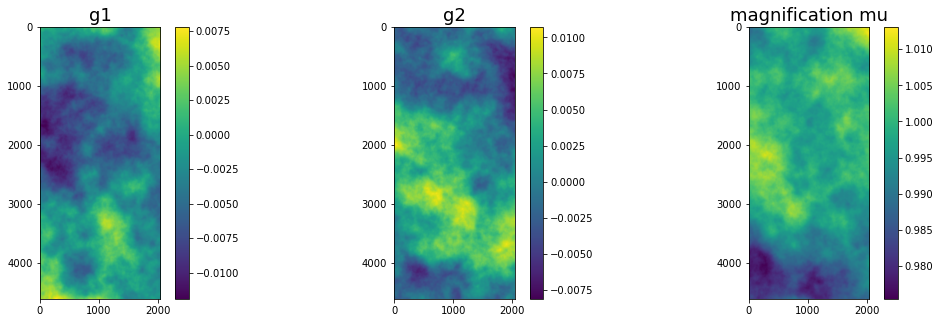

In [82]:
# Plot the entire focal plane
plt.figure(figsize=(18,5))

plt.subplot(131)
plt.imshow(e1_cont);plt.colorbar()
plt.gca().set_title('g1', fontsize='18')

plt.subplot(132)
plt.imshow(e2_cont);plt.colorbar()
plt.gca().set_title('g2', fontsize='18')

plt.subplot(133)
plt.imshow(size_cont**(-3/4));plt.colorbar()
plt.gca().set_title('magnification mu', fontsize='18')

plt.show()

In [83]:
# atmos_cont = np.array([atmos.interpolate_position(_x, _y)
#                        for _x, _y in zip(xx.flatten(), yy.flatten())])


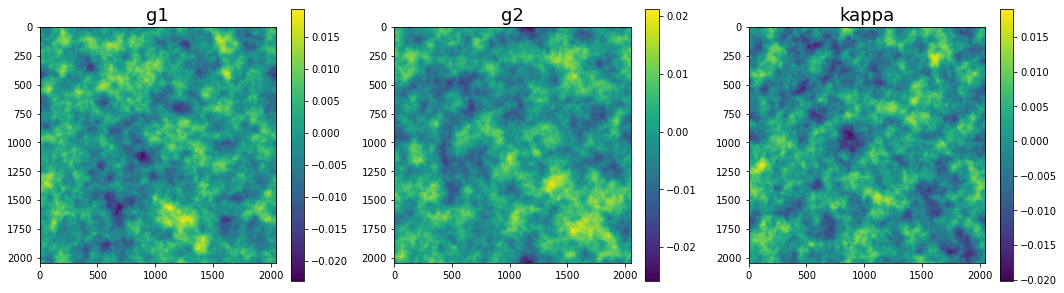

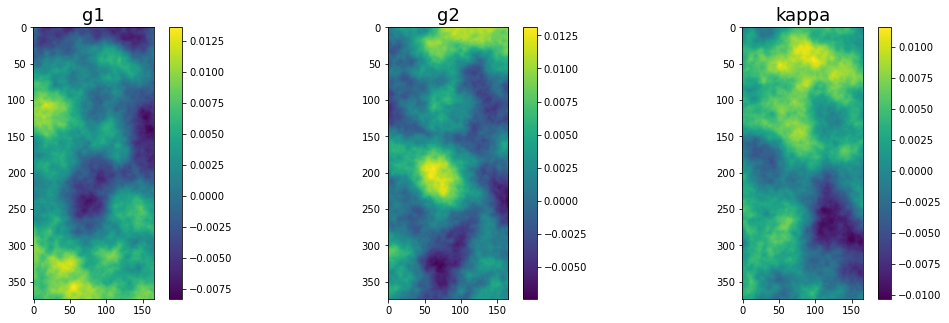

In [84]:
atmos.plot_realisation()